# MTA Data Source:http://web.mta.info/developers/turnstile.html


Data dictionary:    
C/A      = Control Area (a block of turnstiles);
UNIT     = Remote Unit for a station;
SCP      = Subunit Channel Position (designates a single turnstile);
STATION  = Station name;
LINENAME = Concatenation of names of lines going through station (e.g. NQR456, BD,...);
DIVISION = A label with six possible values:
          The first three refer to a time when there were three separate subway systems:  
             IRT = Interborough Rapid Transit;  
             BMT = Brooklyn-Manhattan Transit;  
             IND = Independent Subway;  
          The last three are more recent developments:
             PTH = Port Authority Trans-Hudson (PATH);
             RIT = Roosevelt Island Tram;
             SRT = Staten Island Rapid Transit;
DATE     = Date on which data were collected;
TIME     = Time of collection (every four hours);
DESC     = Characterizes the audit event as either:
          REGULAR (normally every four hours), or
          RECOVR AUD (a missed audit that was recovered);
ENTRIES  = State of entries counter at turnstile at given date and time;
EXITS    = State of exits counter at turnstile at given date and time.

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
from datetime import datetime
from dateutil.parser import parse

baseURL = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
#start_date = date(2019, 9, 21) # 21st September 2019
start_date = date(2019, 6, 1) # 1st June 2019

############## Helper Functions ##############
def string_of_weeks(start_date, number_of_weeks):
    '''
    Returns a list of strings where each string represents a date in "yymmdd" format
    Starting with the "start_date"
    start_date should be a date object
    '''
    #print(start_date.strftime("%y%m%d")) #for testing
    a_week = timedelta(days=7)
    
    list_of_dates = list([start_date.strftime("%y%m%d")])
    
    #Works but not readable
    #list_of_dates += ([(d-week*a_week).strftime("%y%m%d") for week in range(1,number_of_weeks)])
    
    assert number_of_weeks >= 1
    
    for week in range(1, number_of_weeks):
        temp = start_date - week * a_week # a number * timedelta to walk backwards in time
        list_of_dates.append(temp.strftime("%y%m%d"))
    
    return list_of_dates

#print(string_of_weeks(start_date, 52)) #for testing

def create_MTA_dataframe(start_date, number_of_weeks):
    '''
    Returns a panda DataFrame object of MTA turnstile data starting from
    start_date and going back to number_of_weeks
    '''    
    dates_for_downloads = string_of_weeks(start_date, number_of_weeks)
    print(dates_for_downloads)
    list_of_sizes = []
    
    # --- Read the csv file for the first week & strip any whitespaces in the column names
    mta_df = pd.read_csv(baseURL+dates_for_downloads[0]+".txt")
    mta_df.rename(columns = lambda col: col.strip(), inplace=True)
    list_of_sizes.append(mta_df.shape[0])
    #print(type(mta_df)) #for testing
    
    # --- Read the csv file for the rest of the weeks in the dates list
    #    & strip any whitespaces in the column names before appending
    for week in dates_for_downloads[1:]:
        temp = pd.read_csv(baseURL+week+".txt")
        temp.rename(columns = lambda col: col.strip(), inplace=True)
        mta_df = mta_df.append(temp, ignore_index=True)
        #print("Added one dataframen for: " + week+" with rows:"+ str(temp.shape[0]))
        list_of_sizes.append(temp.shape[0])
        
    
    mta_df.info()
    #print(list_of_sizes)
    #print(len(list_of_dfs))
    return mta_df

def add_a_key(list_column_names, mta_data):
    """
    Adds a "key" column by concatenating the columns specified in the "list_column_names"
    Example: To specify "C/A" & "STATION" as keys, call this function using ["C/A", "STATION"]
             for "list_column_names"
    
    returns a pandas DataFrame
    """
    #print(list_column_names)  # for testing
    
    # --- Delete the "key" column if exist & create a brand new key column with empty strings
    if "turnstile_key" in list(mta_data.columns):
        mta_data.drop("turnstile_key", axis=1)
    mta_data["turnstile_key"] = ""
    
    # --- If column name correctly specified and it exists, then add its value to the key
    for col in list_column_names:
        try:
            if col in list(mta_data.columns):
                mta_data["turnstile_key"] += mta_data[col]
        except:
            print("Column {} does not exist in the DataFrame".format(col))
            return None
    
    return mta_data

def add_times_columns(mta_data):
    """
    Adds date/time/day of week/AM-PM columns
    Combines the "DATE" and "TIME" fields into a single colummn of "DATETIME" of datetime data type
    
    Retunrs a pandas DataFrame
    """
    
    list_of_cols = ["DATETIME", "DAY_OF_THE_WEEK", "AM/PM"]
    # --- Delete the time columns if they already exist
    for col in list_of_cols:
        if col in list(mta_data.columns):
            mta_data.drop(col, axis=1)    
    
    # --- DATETIME: Uses parser method from dateutil python library
    #     to convert a string into datetime object  
    #
    # Would this work? mta_data["DATETIME"]=dt.to_datetime(mta_data["DATE"]+" "+mta_data["TIME"])
    #
    mta_data["DATETIME"]=[parse(i) for i in (mta_data["DATE"]+" "+mta_data["TIME"])]
    
    # --- DAY_OF_THE_WEEK: Using standard datetime utils from pandas
    #     to get day of the week from a datetime column
    mta_data["DAY_OF_THE_WEEK"]=mta_data["DATETIME"].dt.weekday_name
    
    # --- AM/PM
    #     Gets AM/PM from a datetime field   
    mta_data["AM/PM"]=[datetime.strftime(dtime, "%p") for dtime in mta_data["DATETIME"]]
    
    # --- Hour
    #     Adds Hour field   
    mta_data['HOUR'] = mta_data['DATETIME'].dt.hour
    
    return mta_data

def add_previous(mta_data):
    """
    Adds the following column data from previous timestamp rows for any turnstile
    "DATETIME" ==> "prev_datetime"
    "TIMESTAMP" ==> "prev_tstamp"
    "ENTRIES" ==> "prev_entries"
    "EXITS" ==> "prev_exits"
    
    'Previous' data is added for multiple columns for data checks and filtering
    """
    #source_prev_cols = ["DATETIME", "tunrstile_key","ENTRIES", "EXITS"]
    
    prev_column_list = ["prev_datetime", "prev_key", 
                        "prev_entries", "prev_exits",
                        "inSeq", "time_step", "DiffEntries"]
    # --- Delete the prev columns if they already exist
    for col in prev_column_list:
        if col in list(mta_data.columns):
            mta_data.drop(col, axis=1)
    '''
    # --- Delete any "prev" columns if exist, ugly version
    if "prev_datetime" in list(mta_data.columns):
        mta_data.drop("prev_datetime")    
    if "prev_key" in list(mta_data.columns):
        mta_data.drop("prev_key")
    if "prev_entries" in list(mta_data.columns):
        mta_data.drop("prev_entries")
    if "prev_exits" in list(mta_data.columns):
        mta_data.drop("prev_exits")
    if "inSeq" in list(mta_data.columns):
        mta_data.drop("inSeq")
    if "time_step" in list(mta_data.columns):
        mta_data.drop("time_step")
    if "DiffEntries" in list(mta_data.columns):
        mta_data.drop("DiffEntries")
    '''
    # --- sort the dataframe first, so you have rows lined up for getting the previous rows
    mta_data.sort_values(by=[ "turnstile_key", "DATETIME"], ascending = [True, True], inplace=True)
    
    mta_data["prev_datetime"] = mta_data["DATETIME"].shift(periods=1)
    mta_data["prev_key"] = mta_data["turnstile_key"].shift(periods=1)
    mta_data["prev_entries"] = mta_data["ENTRIES"].shift(periods=1)
    mta_data["prev_exits"] = mta_data["EXITS"].shift(periods=1)
    mta_data["inSeq"] = (mta_data["prev_datetime"] < mta_data["DATETIME"]) & (mta_data["prev_key"] == mta_data["turnstile_key"])
    mta_data["DiffEntries"]=(mta_data["ENTRIES"]-mta_data["prev_entries"]) * mta_data["inSeq"]
    mta_data["DiffExits"]=(mta_data["EXITS"]-mta_data["prev_exits"]) * mta_data["inSeq"]
    mta_data["time_step"] = (mta_data["DATETIME"] - mta_data["prev_datetime"]) * mta_data["inSeq"]
    
    return mta_data
    

In [2]:
def clean_outliers(mta_data):
    ''' Function to clean the positive and negative turnstile counts
    
    Args: A pandas DataFrame with turnstile entries and exits processed 
    
    Returns: A pandas DataFrame with outlier turnstile entries and exits removed
    
    Filters:
        1. "time_step_hrs" the interval between successive turnstile counts less than 5hrs
           (to avoid malfunctioned turnstiles) 
        2. processed entries and exits that are greater than zero & less than 15000    
    '''
    
    mta_data["time_step_hrs"]  = (mta_data["time_step"]/np.timedelta64(1, 'h'))
    
    filter_time_steps   = (mta_data["time_step_hrs"] <= 5.0) 
    filter_diff_entries = ((mta_data["DiffEntries"] >= 0) & (mta_data["DiffEntries"] < 12000))
    filter_diff_exits = ((mta_data["DiffExits"] >= 0) & (mta_data["DiffExits"] < 12000))

    return mta_data.loc[filter_time_steps & filter_diff_entries & filter_diff_exits]

In [3]:
def sort_neg_positive_turnstiles(mta_data):
    """Creates a list of turnstiles that have negative processed entries/exits
    
    Args: A pandas DataFrame with processed entries and exits
    
    Returns: A tuple two lists: one with turnstile keys that have atleast one negative entry, and one 
             with turnstiles without any negative numbers
    """
    # --- Filter for turnstiles with negative entries or exits to catch counter resets
    filter_for_negs = (mta_data["DiffEntries"] < 0) | (mta_data["DiffExits"] < 0)
    neg_turnstiles = mta_data[filter_for_negs]['turnstile_key'].unique()
    
    pos_turnstiles = list(uniq_keys)
    for neg_turn in neg_turnstiles:
        pos_turnstiles.remove(neg_turn)
        #print(neg_turn)
    print(len(pos_turnstiles))
    
    return (neg_turnstiles, pos_turnstiles)
    

In [4]:
# --- Step 1. Download data
# --- Step 2. Add a key to identify turnstile
# --- Step 3. Add time related columns
# --- Step 4. Add columns that shifts the rows by one - calling these "prev" for previous timestamp values
#
mta_df = create_MTA_dataframe(start_date, 9)
mta_df_wKey = add_a_key(["C/A", "UNIT", "SCP", "STATION"], mta_df)
mta_df_wTimestamp = add_times_columns(mta_df_wKey)
mta_df_wp = add_previous(mta_df_wTimestamp)

['190601', '190525', '190518', '190511', '190504', '190427', '190420', '190413', '190406']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840863 entries, 0 to 1840862
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 154.5+ MB


In [5]:
mta_df_wPrev = clean_outliers(mta_df_wp)

In [6]:
# --- Stats about the data:
#
#
uniq_CAs = mta_df_wTimestamp['C/A'].unique()
uniq_units = mta_df_wTimestamp['UNIT'].unique()
uniq_scps = mta_df_wTimestamp['SCP'].unique()
uniq_stations = mta_df_wTimestamp['STATION'].unique()
uniq_linenames = mta_df_wTimestamp['LINENAME'].unique()
uniq_divis = mta_df_wTimestamp['LINENAME'].unique()
uniq_keys = mta_df_wTimestamp['turnstile_key'].unique()

print("Number of unique C/A: "+str(len(uniq_CAs)))
print("Number of unique UNIT: "+str(len(uniq_units)))
print("Number of unique SCP: "+str(len(uniq_scps)))
print("Number of unique STATION: "+str(len(uniq_stations)))
print("Number of unique LINENAME: "+str(len(uniq_linenames)))
print("Number of unique Turnstile key: "+str(len(uniq_keys)))

Number of unique C/A: 745
Number of unique UNIT: 468
Number of unique SCP: 223
Number of unique STATION: 378
Number of unique LINENAME: 114
Number of unique Turnstile key: 4892


In [35]:
mta_df_wPrev["Station_lin"]= mta_df_wPrev["STATION"]+mta_df_wPrev["LINENAME"]
mta_df_wPrev

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,prev_key,prev_entries,prev_exits,inSeq,DiffEntries,DiffExits,time_step,time_step_hrs,PASSENGERS,Station_lin
1637900,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,...,A002R05102-00-0059 ST,6999064.0,2373568.0,True,20.0,8.0,04:00:00,4.000000,28.0,59 STNQR456W
1637901,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,...,A002R05102-00-0059 ST,6999084.0,2373576.0,True,23.0,46.0,04:00:00,4.000000,69.0,59 STNQR456W
1637902,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,...,A002R05102-00-0059 ST,6999107.0,2373622.0,True,107.0,88.0,04:00:00,4.000000,195.0,59 STNQR456W
1637903,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,...,A002R05102-00-0059 ST,6999214.0,2373710.0,True,237.0,71.0,04:00:00,4.000000,308.0,59 STNQR456W
1637904,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,...,A002R05102-00-0059 ST,6999451.0,2373781.0,True,345.0,56.0,04:00:00,4.000000,401.0,59 STNQR456W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203790,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/31/2019,09:00:00,REGULAR,5554,...,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,378.0,True,0.0,0.0,01:19:52,1.331111,0.0,RIT-ROOSEVELTR
203791,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/31/2019,12:10:52,REGULAR,5554,...,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,378.0,True,0.0,0.0,03:10:52,3.181111,0.0,RIT-ROOSEVELTR
203792,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/31/2019,13:00:00,REGULAR,5554,...,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,378.0,True,0.0,0.0,00:49:08,0.818889,0.0,RIT-ROOSEVELTR
203793,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/31/2019,17:00:00,REGULAR,5554,...,TRAM2R46900-05-01RIT-ROOSEVELT,5554.0,378.0,True,0.0,0.0,04:00:00,4.000000,0.0,RIT-ROOSEVELTR


In [22]:
def summation_of_passengers(mta_data):
    '''
    Input: MTA dataframe 
    Output: Adding a new column with the sum of DiffEntries+DiffExits called PASSENGERS
    
    '''
    col_list = ['DiffEntries', 'DiffExits']
    
    mta_data['PASSENGERS'] = mta_data[col_list].sum(axis=1)
    
    
#     empty_col = []
#     for i,j in mta_data['DiffEntries'], mta_data['DiffExits']:
#         empty_col.append(i+j)
    
    return mta_data
    

def creating_final_df(mta_data, string_col_names):
    '''
    Input: MTA dataframe and a list of string of column names you want from the new dataframe
    Output: A clean dataframe with the following columns...
        columns: STATION, DAY_OF_THE_WEEK, HOUR, PASSENGERS
    '''
    #appending_cols(string_col_names)
    
    mta_fin = pd.DataFrame()
    mta_fin.is_copy = False
    for colname in string_col_names:
        mta_fin[colname] = mta_data[colname]    
    #
    #  Above "for" loop throws an error
    #  SettingWithCopyWarning: 
    #  A value is trying to be set on a copy of a slice from a DataFrame.
    #  Try using .loc[row_indexer,col_indexer] = value instead
    #

    #mta_final = mta_data.loc[:,string_col_names]
    
    return mta_fin

In [36]:
summation_of_passengers(mta_df_wPrev)
mta_final = creating_final_df(mta_df_wPrev, ['Station_lin', 'DAY_OF_THE_WEEK', 'HOUR', 'PASSENGERS'])

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [37]:
mta_final

,Station_lin,DAY_OF_THE_WEEK,HOUR,PASSENGERS
1637900,59 STNQR456W,Saturday,4,28.0
1637901,59 STNQR456W,Saturday,8,69.0
1637902,59 STNQR456W,Saturday,12,195.0
1637903,59 STNQR456W,Saturday,16,308.0
1637904,59 STNQR456W,Saturday,20,401.0
...,...,...,...,...
203790,RIT-ROOSEVELTR,Friday,9,0.0
203791,RIT-ROOSEVELTR,Friday,12,0.0
203792,RIT-ROOSEVELTR,Friday,13,0.0
203793,RIT-ROOSEVELTR,Friday,17,0.0


AttributeError: module 'matplotlib' has no attribute 'title'

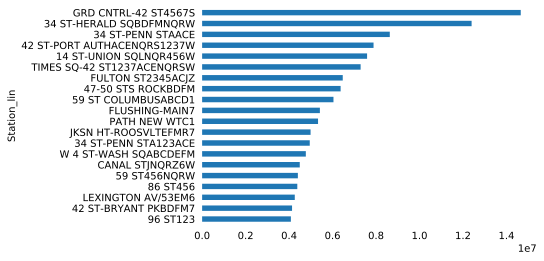

In [40]:
import matplotlib as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

Station_Volume_Graph=mta_final.groupby('Station_lin')['PASSENGERS'].sum().sort_values(ascending=False)[:20].plot(kind='barh')
#Despine top and right
Station_Volume_Graph.spines['right'].set_visible(False)
Station_Volume_Graph.spines['top'].set_visible(False)
Station_Volume_Graph.spines['left'].set_visible(False)
Station_Volume_Graph.spines['bottom'].set_visible(False)
#Remove Ticks
Station_Volume_Graph.tick_params(
    axis='both',      # changes apply to both axes
    which='both',     # both major and minor ticks are affected
    left=False,       #ticks along the left edge are off
    bottom=False,     # ticks along the bottom edge are off
    top=False,        # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
#Invert Y-axis
Station_Volume_Graph.axes.invert_yaxis()
plt.title('Top 10 Stations by Rider Volume')

In [32]:
mta_df_wPrev[mta_df_wPrev["STATION"] == "34 ST-PENN STA"]["LINENAME"].unique()
mta_df_wPrev[mta_df_wPrev["STATION"] == "23 ST"]["LINENAME"].unique()

array(['NRW', 'CE', 'FM', '1', '6'], dtype=object)

In [45]:
gb = mta_final.groupby(['Station_lin', 'HOUR'])
gb_agg = gb.agg({"DAY_OF_THE_WEEK": ['count']})
gb_agg.sample(10)

,,DAY_OF_THE_WEEK
,,count
Station_lin,HOUR,
WORLD TRADE CTRACE23,8,1319
GRD CNTRL-42 ST4567S,16,1953
THIRTY ST1,18,240
125 ST23,9,449
DEKALB AVL,0,291
WORLD TRADE CTRACE23,16,1103
KINGSBRIDGE RDBD,1,753
170 ST4,16,252


In [47]:
hrs = mta_final["HOUR"].unique()
hrs

array([ 4,  8, 12, 16, 20,  0,  9, 11, 10,  2,  6, 14, 18, 22,  7,  1,  5,
       13, 17, 21, 23, 15,  3, 19])